In [3]:
import pandas as pd
import numpy as np
import scipy.stats

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

# plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

In [ ]:
filepath = "../data/Household/top_features_handpicked.xlsx"

# load data file and variable types
DATA = pd.read_excel(filepath)

In [396]:
def weighted_hamming(X):
    # compute number of categories per feature
    pi_k = np.zeros(len(X.columns))
    for i, col in enumerate(X.columns):
        pi_k[i] = len(X[col].unique())
    pi_k = 1/pi_k

    X = np.array(X)

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H

In [397]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

___

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


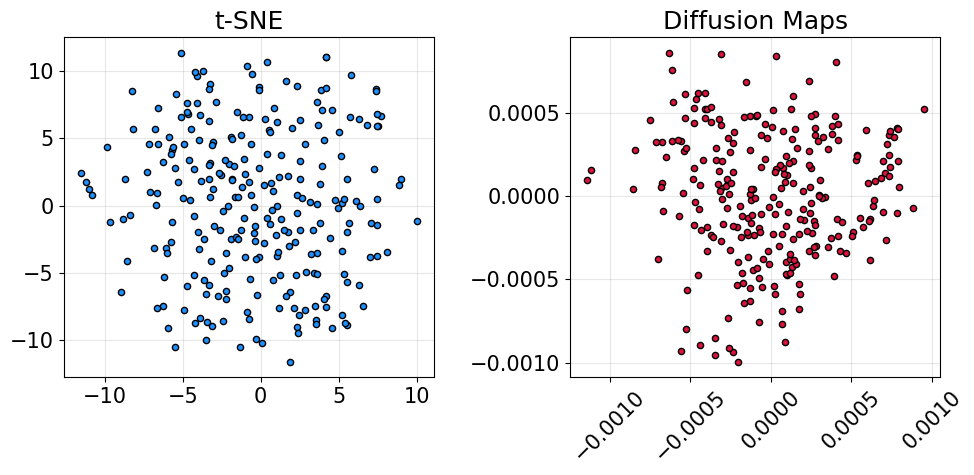

In [379]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

no_empty = []
for index, row in DATA.iterrows():
    if -1 in list(row):
        continue
    else:
        no_empty.append(row)

DATA = pd.concat(no_empty, axis=1).T
        
X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA))


ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0].set_title("t-SNE")

D = cosine_distances(X_one_hot)
dm_coords = diffusionmap(D, len(DATA), 2, 0.5, 2)
axs[1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[1].set_title("Diffusion Maps")
axs[1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

In [398]:
no_empty = []
for index, row in DATA.iterrows():
    if -1 in list(row):
        continue
    else:
        no_empty.append(row)

DATA = pd.concat(no_empty, axis=1).T

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


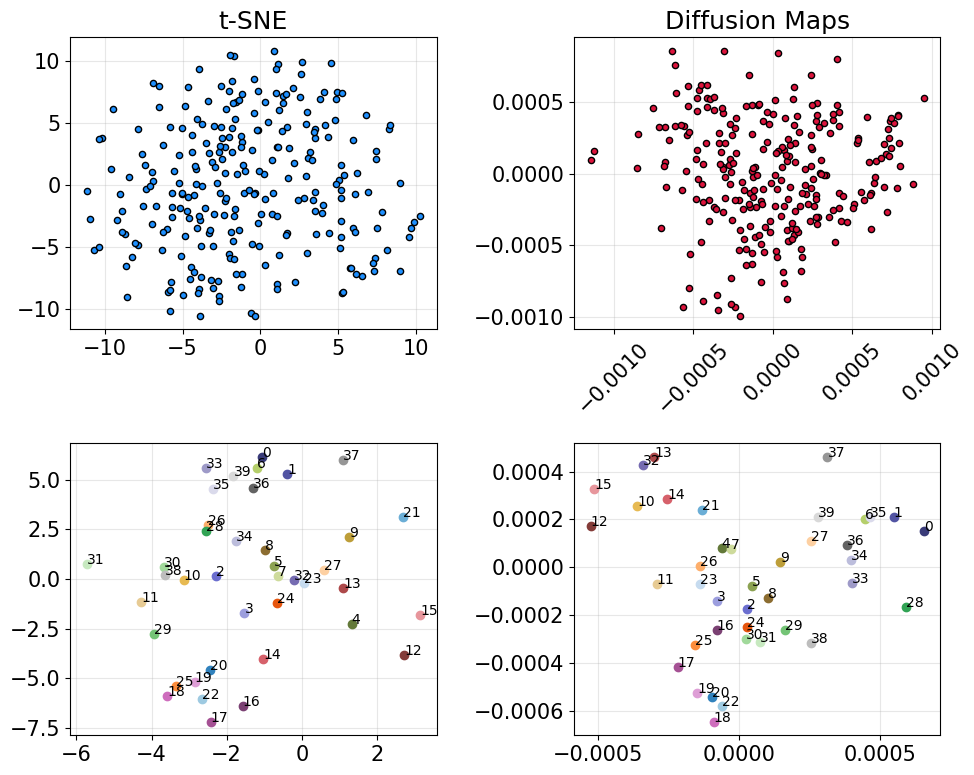

In [431]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
        
X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA))


ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0][0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0][0].set_title("t-SNE")

communities_tsne = {i:[] for i in range(40)}
for i, row in enumerate(tsne_coords):
    communities_tsne[DATA.iloc[i]["community_code"]].append(row)

for c in communities_tsne:
    combined = np.row_stack(communities_tsne[c])
    combined = np.mean(combined, axis=0)
    if c < 20:
        axs[1][0].scatter(combined[0], combined[1], color=cm.tab20b(c%20))
    else:
        axs[1][0].scatter(combined[0], combined[1], color=cm.tab20c(c%20))
        
    axs[1][0].annotate(c, (combined[0], combined[1]), fontsize=10)
        
        
D = cosine_distances(X_one_hot)
dm_coords = diffusionmap(D, len(DATA), 2, 0.5, 2)
axs[0][1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[0][1].set_title("Diffusion Maps")
axs[0][1].tick_params(axis='x', labelrotation = 45)

communities_dm = {i:[] for i in range(40)}
for i, row in enumerate(dm_coords):
    communities_dm[DATA.iloc[i]["community_code"]].append(row)
    
for c in communities_dm:
    combined = np.row_stack(communities_dm[c])
    combined = np.mean(combined, axis=0)    
    if c < 20:
        axs[1][1].scatter(combined[0], combined[1], color=cm.tab20b(c%20))
    else:
        axs[1][1].scatter(combined[0], combined[1], color=cm.tab20c(c%20))
        
    axs[1][1].annotate(c, (combined[0], combined[1]), fontsize=10)

plt.tight_layout()
plt.savefig("tsne_dm_bccas.pdf", bbox_inches="tight")
plt.show()

In [432]:
communities_dm = {k: np.mean(np.row_stack(v), axis=0) for k,v in communities_dm.items()}

In [433]:
communities_tsne = {k: np.mean(np.row_stack(v), axis=0) for k,v in communities_tsne.items()}

In [444]:
dm_stacked = np.row_stack(list(communities_dm.values()))
dm_Dist = euclidean_distances(dm_stacked)
dm_dist_vals = []
for i in range(dm_Dist.shape[0]):
    for j in range(i+1, dm_Dist.shape[0]):
        dm_dist_vals.append(dm_Dist[i][j])

In [445]:
tsne_stacked = np.row_stack(list(communities_tsne.values()))
tsne_Dist = euclidean_distances(tsne_stacked)
tsne_dist_vals = []
for i in range(tsne_Dist.shape[0]):
    for j in range(i+1, tsne_Dist.shape[0]):
        tsne_dist_vals.append(tsne_Dist[i][j])

(0.5691122553876133, 3.77590434199743e-68)
(0.5141402000514871, 7.604459173463062e-54)
(0.3178715903628152, 8.990849101017e-20)


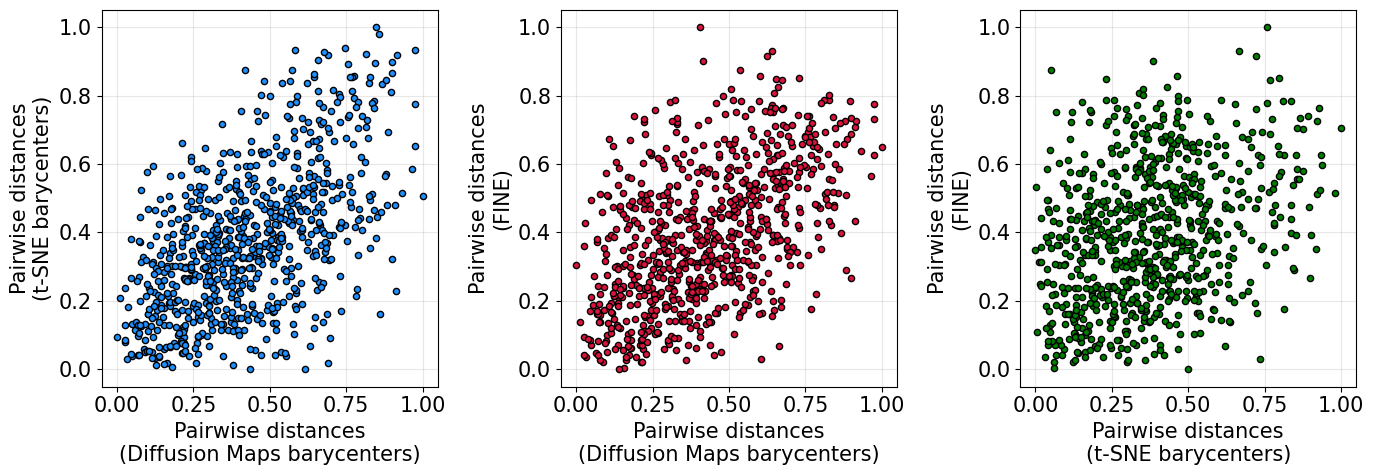

In [481]:
fig, axs = plt.subplots(1, 3, figsize=(14,5))

colors = ["dodgerblue", "crimson", "green"]

xlabels = ["Pairwise distances\n(Diffusion Maps barycenters)",
           "Pairwise distances\n(Diffusion Maps barycenters)",
           "Pairwise distances\n(t-SNE barycenters)"]

ylabels = ["Pairwise distances\n(t-SNE barycenters)",
           "Pairwise distances\n(FINE)",
           "Pairwise distances\n(FINE)"]


for i, pair in enumerate([(dm_dist_vals, tsne_dist_vals), 
                          (dm_dist_vals, handpicked_dist_vals), 
                          (tsne_dist_vals, handpicked_dist_vals)]):
    
    x = (pair[0] - min(pair[0])) / (max(pair[0]) - min(pair[0]))
    y = (pair[1] - min(pair[1])) / (max(pair[1]) - min(pair[1]))

    axs[i].scatter(x, y, color=colors[i], edgecolor="k", s=20)
    
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_ylabel(ylabels[i])
    
    print(pearsonr(x, y))
    

fig.tight_layout()
plt.savefig("pairwise_correlations.pdf", bbox_inches="tight")
plt.show()